Prerequisites
=============

* astropy
* Pickle files containing the lightcurves from generate_lightcurves.ipynb

In [12]:
%matplotlib inline
from __future__ import print_function, division
import matplotlib.pyplot as plt
import numpy as np
import cPickle

from astropy.stats import LombScargle

plt.style.use(['ggplot', 'ggplot_mod.mplstyle', 'notebooks.mplstyle'])

RR Lyrae
========

In [4]:
# Load from the pickle file
f = open("rrlyrae_lightcurves.pkl")
rrlyrae_lc, rrlyrae_truth = cPickle.load(f)
f.close()

`rrlyrae_lc` is a dictionary, and each entry is a single object identified by an object id.

We can pick the first object with:

In [29]:
single_rrlyrae = rrlyrae_lc[rrlyrae_lc.keys()[1]]

Inside that light curve is a dictionary of different photometric bands:

In [13]:
print(single_rrlyrae.keys())

['i', 'r', 'z', 'g']


Each of which contains the date, magnitude, and magnitude error of the observation:

In [14]:
print(single_rrlyrae['r'].keys())

['mjd', 'mag', 'error']


**Important note**: The `mag` column is the exact value of the model light curve *with no photometric error*. If you want to obtain as-observed magnitudes, you will need to add scatter according to the error column.

Let's plot a single light curve, in all bands:

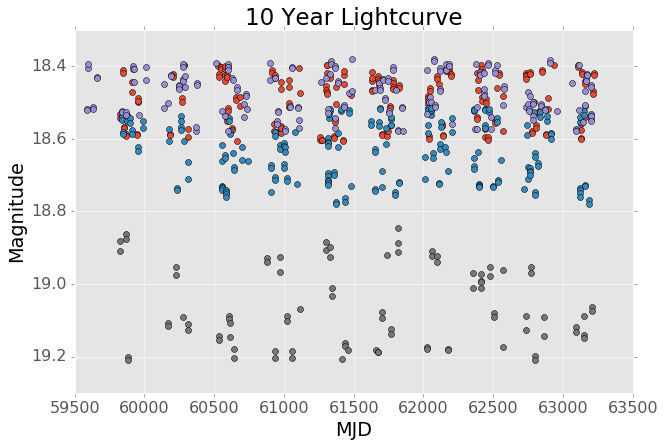

In [30]:
for band, band_data in single_rrlyrae.items():
    plt.plot(band_data['mjd'], band_data['mag'], 'o')
    
plt.xlabel("MJD")
plt.ylabel("Magnitude")
plt.gca().invert_yaxis()
plt.title("10 Year Lightcurve")

This is a full 10 years of data. You can see each observing season grouped together.

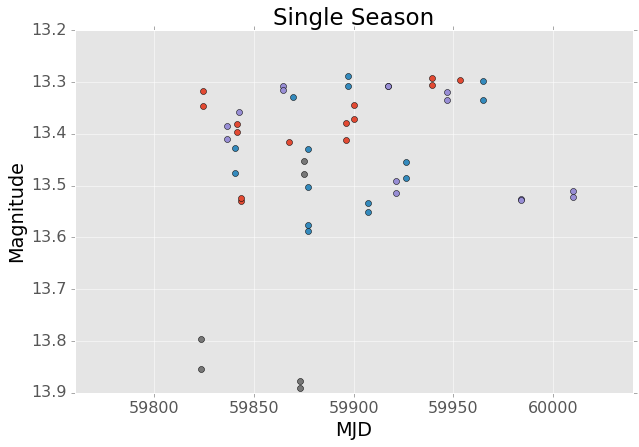

In [23]:
for band, band_data in single_rrlyrae.items():
    plt.plot(band_data['mjd'], band_data['mag'], 'o')
    
plt.xlabel("MJD")
plt.ylabel("Magnitude")
plt.gca().invert_yaxis()
plt.xlim(59900 - 140, 59900 + 140)
plt.title("Single Season")

Finding the RR Lyrae Period
---------------------------

To turn this into something more intuitive, we need to fold the light curve, which means we need to know the period. We can create a simple Lomb-Scargle periodogram to give us a rough estimate of this period.

RR Lyrae Period: 0.736842 days


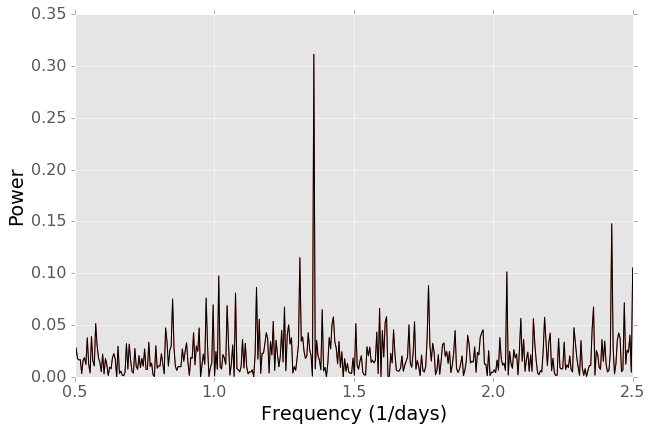

In [76]:
freqs = np.linspace(0.5, 2.5, 400)
#freqs = np.linspace(1.0, 1.5, 400)
total_power = np.zeros(len(freqs))
for band, band_data in single_rrlyrae.items():
    power = LombScargle(band_data['mjd'], band_data['mag']).power(freqs)
    plt.plot(freqs, power)
    total_power =+ power
    break

plt.plot(freqs, total_power, 'k-')
plt.xlabel("Frequency (1/days)")
plt.ylabel("Power")

peak_period = 1/freqs[argmax(total_power)]
print("RR Lyrae Period: {:f} days".format(peak_period))

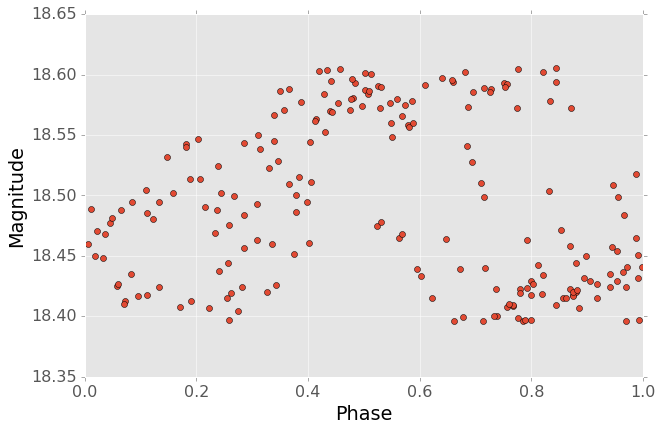

In [112]:
trial_period = peak_period #- 0.018*peak_period*1/(365*10.0)
#trial_period = 0.738330
for band, band_data in single_rrlyrae.items():
    phase = (band_data['mjd'])/trial_period % 1
    plt.plot(phase, band_data['mag'], 'o')
    break
    
plt.ylabel("Magnitude")
plt.xlabel("Phase")

In [116]:
(1/freqs[1] - 1/freqs[0])/peak_period

-0.026940801134349476

In [113]:
(peak_period - 0.738330)/0.738330

-0.0020152164165646632

In [33]:
single_rrlyrae_truth = rrlyrae_truth[rrlyrae_lc.keys()[1]]
print(single_rrlyrae_truth)

{"pars":{"filename":"rrly_lc/RRab/98874_per.txt", "tStartMjd":3.345161432382836e+004}, "varMethodName":"applyRRly"}


Debugging
=========

Below here are some snippets that were useful in debugging some of this code. This can be safely ignored by most users.

The first part extracts the true period from the truth dictionary. This requires the `sims_sed_library` package to be installed, so it is not available with just the pickle files.

In [114]:
import eups
import os
import ast

base_dir = eups.productDir("sims_sed_library")

single_rrlyrae_truth = ast.literal_eval(rrlyrae_truth[rrlyrae_lc.keys()[1]])

truth_filename = os.path.join(base_dir, single_rrlyrae_truth['pars']['filename'])
f = open(truth_filename)
with open(truth_filename) as f:
    for n, line in enumerate(f):
        m = re.match("# Period .* (\d*\.\d*)", line)
        if m:
            period = float(m.group(1))
            print("Period: {:f}".format(period))
        if n > 5:
            break

Period: 0.738330
